In [227]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process


In [228]:
outfield_df = pd.read_csv("combined_data/outfield_stats.csv")
# print number of rows in outfield_df
print(outfield_df.shape[0])

14696


# Preprocessing

In [229]:
# Parameters
MINUTE_CUT_OFF = 450 # 5 games
AGE_VALUATION_YEAR = 2024
YEAR_STRING = "2024-2025"

In [230]:
# only consider 2024 season, the column of scouting period must have the string "2024-2025"
outfield_df = outfield_df[outfield_df['scouting_period'].str.contains(YEAR_STRING)]
print(f"Number of outfield player records after filtering: {len(outfield_df)}")


Number of outfield player records after filtering: 2106


Remove duplicates

In [231]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 2106
Number of outfield player records after dropping duplicates: 2106


Visualising and dropping rows where with players that didn't play enough for sample to be representative

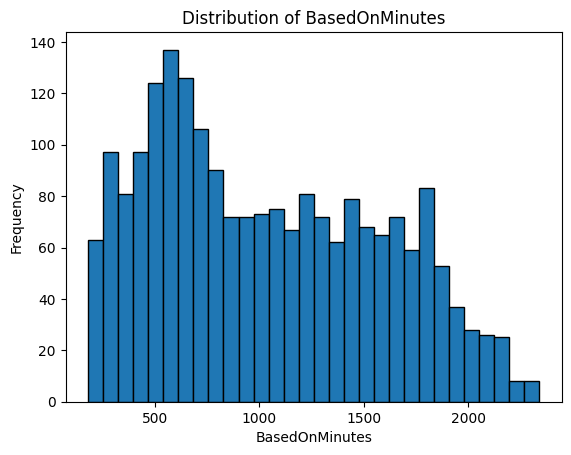

In [232]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [233]:
# Dropping all entries with BasedOnMinutes less than MINUTE_CUT_OFF min
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= MINUTE_CUT_OFF]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 2106
Number of outfield outfield records after filtering: 1806


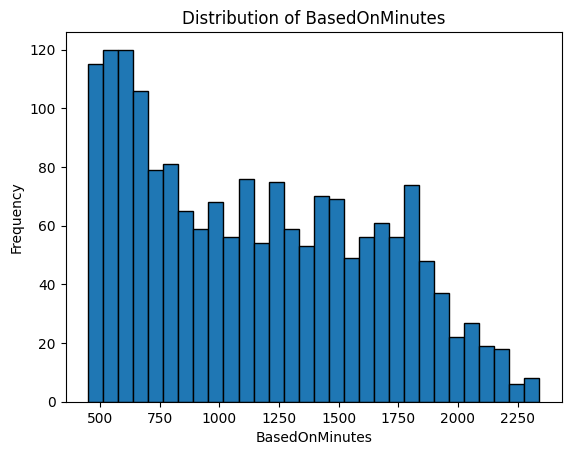

In [234]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

Dropping rows with "Last 365 Days Men's Big 5 Leagues"

In [235]:
# Drop rows where scouting_period is "Last 365 Days Men's Big 5 Leagues"
outfield_df = outfield_df[outfield_df['scouting_period'] != "Last 365 Days Men's Big 5 Leagues"]

Dropping Percentile data 

In [236]:
print(f"Number of outfield player records before dropping Percentile: {outfield_df.shape[1]}")
columns_to_drop = [col for col in outfield_df.columns if 'Percentile' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)
print(f"Number of outfield player records after dropping Percentile: {outfield_df.shape[1]}")

Number of outfield player records before dropping Percentile: 238
Number of outfield player records after dropping Percentile: 121


Handling na values

In [237]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [238]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 243


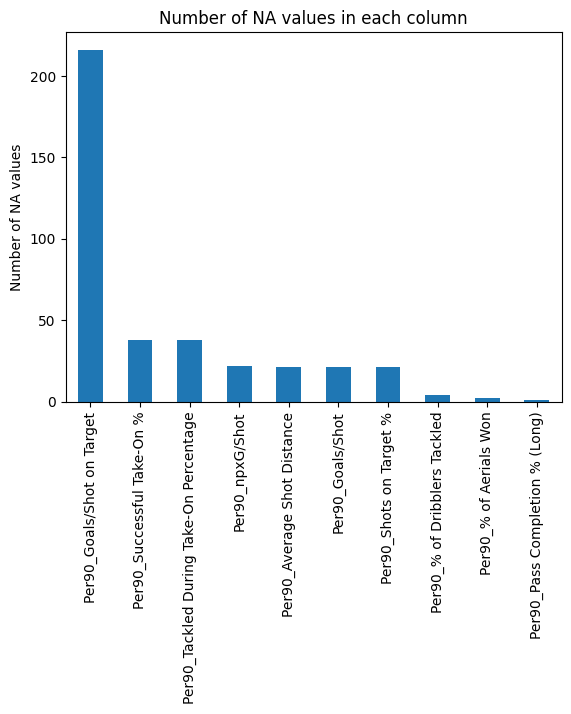

In [239]:
# Visualise columns with na values, sort from highest to lowest
na_columns = outfield_df.isnull().sum()
na_columns = na_columns[na_columns > 0]
na_columns = na_columns.sort_values(ascending=False)
na_columns.plot(kind='bar')
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.show()

In [240]:
# If Per90 is not dropped
na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
                                 'Per90_npxG/Shot', 
                                 'Per90_Average Shot Distance', 
                                 'Per90_Goals/Shot', 
                                 'Per90_Shots on Target %']
na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
                                    'Per90_Tackled During Take-On Percentage']
na_columns_others = ['Per90_% of Dribblers Tackled',
                    'Per90_% of Aerials Won',
                    'Per90_Pass Completion % (Long)']
def get_existing_columns(df, *column_lists):
    existing_cols = []
    for col_list in column_lists:
        existing_cols.extend([col for col in col_list if col in df.columns])
    return existing_cols

# Get all existing columns from the three lists
existing_columns = get_existing_columns(outfield_df, 
                                        na_columns_goal_related_per90, 
                                        na_columns_dribble_related_per90, 
                                        na_columns_others)

outfield_df[existing_columns] = outfield_df[existing_columns].fillna(0)

In [241]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Combining rows to ensure that one entry is tagged to only one unique player

In [242]:
print(outfield_df.dtypes)

Player                             object
Versus                             object
BasedOnMinutes                      int64
scouting_period                    object
Per90_% of Aerials Won            float64
                                   ...   
Per90_npxG/Shot                   float64
Per90_npxG: Non-Penalty xG        float64
Per90_xA: Expected Assists        float64
Per90_xAG: Exp. Assisted Goals    float64
Per90_xG: Expected Goals          float64
Length: 121, dtype: object


In [243]:
# Drop non-numeric column "scouting_period"
outfield_df = outfield_df.drop(columns=["scouting_period"], errors="ignore")

# Define numeric columns excluding categorical ones
numeric_cols = [col for col in outfield_df.columns if col not in ['Player', 'Versus', 'BasedOnMinutes']]

# Compute weighted averages for numeric stats
weighted_avg_df = outfield_df.groupby("Player").apply(
    lambda group: pd.Series(
        {col: np.average(group[col], weights=group["BasedOnMinutes"]) for col in numeric_cols}
    )
).reset_index()

# Drop "BasedOnMinutes" since it's no longer needed
outfield_df = weighted_avg_df.drop(columns=["BasedOnMinutes"], errors="ignore")

outfield_df.head(10)

/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_43057/2090541934.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_df = outfield_df.groupby("Player").apply(


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Def Pen),Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals
0,Aaron Wan-Bissaka,38.500000,70.600000,0.840000,0.530000,0.050000,15.500000,5.360000,1.000000,27.460000,...,4.460000,60.230000,25.410000,0.050000,0.120000,0.090000,0.050000,0.080000,0.060000,0.050000
1,Aarón Martín,39.000000,67.600000,1.030000,0.660000,0.120000,23.900000,3.970000,1.160000,23.290000,...,2.850000,56.250000,23.080000,0.170000,0.210000,0.060000,0.030000,0.200000,0.180000,0.030000
2,Abakar Sylla,59.400000,87.500000,1.410000,2.060000,0.000000,9.000000,3.800000,1.730000,41.200000,...,14.310000,76.230000,24.510000,0.220000,0.040000,0.080000,0.040000,0.010000,0.000000,0.040000
3,Abdallah Sima,49.801466,65.107331,3.169179,3.167742,0.131789,13.345455,4.881848,0.528006,21.708152,...,0.927654,37.016334,13.920997,0.198827,0.455865,0.134897,0.352141,0.078622,0.091173,0.352141
4,Abde Ezzalzouli,39.600000,55.000000,1.710000,1.120000,0.060000,15.800000,4.850000,1.000000,32.270000,...,0.470000,49.880000,19.030000,0.120000,0.460000,0.130000,0.370000,0.090000,0.100000,0.410000
5,Abdel Abqar,53.000000,61.500000,1.380000,1.550000,0.040000,7.500000,3.240000,0.890000,24.720000,...,5.950000,48.060000,21.170000,0.530000,0.040000,0.080000,0.040000,0.020000,0.010000,0.040000
6,Abdou Harroui,53.300000,100.000000,1.360000,1.560000,0.390000,17.700000,4.280000,0.970000,34.020000,...,0.970000,55.010000,27.990000,0.190000,0.510000,0.150000,0.430000,0.120000,0.080000,0.430000
7,Abdoulaye Bamba,55.600000,75.000000,0.740000,0.930000,0.000000,0.000000,2.600000,0.840000,27.930000,...,5.380000,46.390000,20.410000,0.190000,0.030000,0.000000,0.000000,0.030000,0.030000,0.000000
8,Abdoulaye Doucouré,55.900000,36.800000,0.950000,1.200000,0.000000,15.800000,5.240000,1.200000,21.730000,...,1.520000,42.510000,20.210000,0.060000,0.110000,0.080000,0.060000,0.040000,0.060000,0.060000
9,Abdoulaye Niakhate Ndiaye,55.900000,61.900000,2.300000,2.910000,0.000000,9.300000,3.360000,1.320000,30.290000,...,9.800000,60.940000,23.050000,0.270000,0.060000,0.110000,0.050000,0.020000,0.000000,0.050000


Merge with age_data

In [244]:
age_valuation_df = pd.read_csv("combined_data/age-valuation.csv")
age_valuation_df = age_valuation_df[age_valuation_df['season_start_year'] == AGE_VALUATION_YEAR]
# drop duplicates
print(f"Number of age valuation records before dropping duplicates: {len(age_valuation_df)}")
age_valuation_df = age_valuation_df.drop_duplicates(subset=['Player'])
print(f"Number of age valuation records after dropping duplicates: {len(age_valuation_df)}")

Number of age valuation records before dropping duplicates: 2561
Number of age valuation records after dropping duplicates: 2069


In [245]:
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_valuation_df['Player'])

    if score >= 70:
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

outfield_df = outfield_df.merge(
    age_valuation_df[['Player', 'age']], 
    on="Player", 
    how="left"
)

print(f"Number of na values in Age: {outfield_df['age'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['age'])
print(f"Number of na values in Age after dropping: {outfield_df['age'].isna().sum()}")

print("Merging completed successfully!")
outfield_df.head(10)

Number of na values in Age: 140
Number of na values in Age after dropping: 0
Merging completed successfully!


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,age
0,Aaron Wan-Bissaka,38.500000,70.600000,0.840000,0.530000,0.050000,15.500000,5.360000,1.000000,27.460000,...,60.230000,25.410000,0.050000,0.120000,0.090000,0.050000,0.080000,0.060000,0.050000,27.0
1,Aarón Martín,39.000000,67.600000,1.030000,0.660000,0.120000,23.900000,3.970000,1.160000,23.290000,...,56.250000,23.080000,0.170000,0.210000,0.060000,0.030000,0.200000,0.180000,0.030000,27.0
2,Abakar Sylla,59.400000,87.500000,1.410000,2.060000,0.000000,9.000000,3.800000,1.730000,41.200000,...,76.230000,24.510000,0.220000,0.040000,0.080000,0.040000,0.010000,0.000000,0.040000,22.0
3,Abdallah Sima,49.801466,65.107331,3.169179,3.167742,0.131789,13.345455,4.881848,0.528006,21.708152,...,37.016334,13.920997,0.198827,0.455865,0.134897,0.352141,0.078622,0.091173,0.352141,23.0
4,Abde Ezzalzouli,39.600000,55.000000,1.710000,1.120000,0.060000,15.800000,4.850000,1.000000,32.270000,...,49.880000,19.030000,0.120000,0.460000,0.130000,0.370000,0.090000,0.100000,0.410000,23.0
5,Abdel Abqar,53.000000,61.500000,1.380000,1.550000,0.040000,7.500000,3.240000,0.890000,24.720000,...,48.060000,21.170000,0.530000,0.040000,0.080000,0.040000,0.020000,0.010000,0.040000,25.0
6,Abdou Harroui,53.300000,100.000000,1.360000,1.560000,0.390000,17.700000,4.280000,0.970000,34.020000,...,55.010000,27.990000,0.190000,0.510000,0.150000,0.430000,0.120000,0.080000,0.430000,27.0
7,Abdoulaye Bamba,55.600000,75.000000,0.740000,0.930000,0.000000,0.000000,2.600000,0.840000,27.930000,...,46.390000,20.410000,0.190000,0.030000,0.000000,0.000000,0.030000,0.030000,0.000000,34.0
8,Abdoulaye Doucouré,55.900000,36.800000,0.950000,1.200000,0.000000,15.800000,5.240000,1.200000,21.730000,...,42.510000,20.210000,0.060000,0.110000,0.080000,0.060000,0.040000,0.060000,0.060000,32.0
9,Amath Ndiaye,55.900000,61.900000,2.300000,2.910000,0.000000,9.300000,3.360000,1.320000,30.290000,...,60.940000,23.050000,0.270000,0.060000,0.110000,0.050000,0.020000,0.000000,0.050000,28.0


Log the distribution of player market value

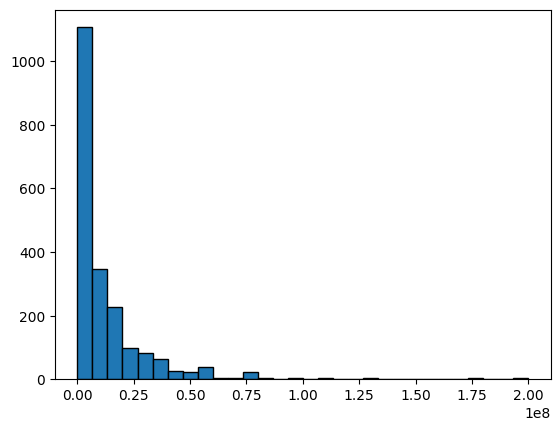

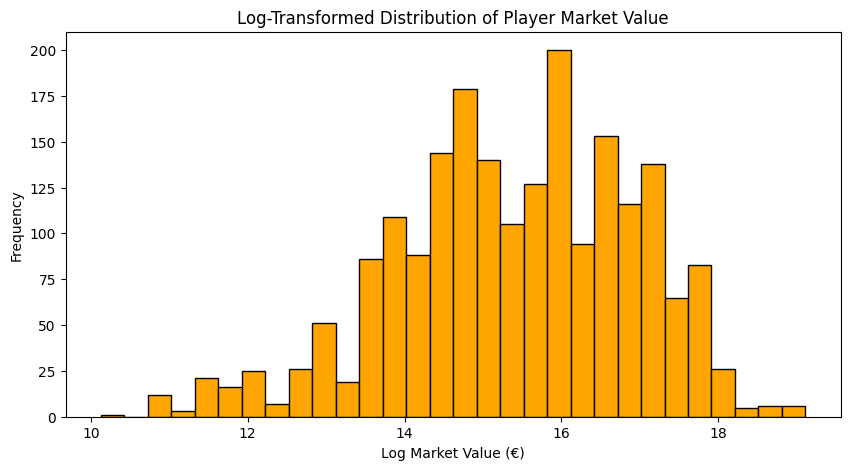

In [246]:

# visualise distribution of player market value
plt.hist(age_valuation_df['player_market_value_euro'], bins=30, edgecolor='k')

# log visualisation
log_values = np.log1p(age_valuation_df['player_market_value_euro'])  # log(1 + x) to avoid log(0) issues

# Log visualisation
plt.figure(figsize=(10, 5))
plt.hist(log_values, bins=30, edgecolor='k', color='orange')
plt.xlabel('Log Market Value (€)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Player Market Value')
plt.show()

# convert player_market_value to a log scale
age_valuation_df['player_market_value_euro'] = np.log(age_valuation_df['player_market_value_euro'])


Merge data with valuation

In [247]:


# Change 'Player' value in outfield_df to that in age_valuation_df if fuzzy matching
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_valuation_df['Player'])

    if score >= 70:
        # replace name with best_match
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

# Merge only player_market_value_euro for 2024 season
outfield_df = outfield_df.merge(
    age_valuation_df[['Player', 'player_market_value_euro']], 
    on="Player", 
    how="left"
)

# Print number of na values in player_market_value_euro
print(f"Number of na values in player_market_value_euro: {outfield_df['player_market_value_euro'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['player_market_value_euro'])
print(f"Number of na values in player_market_value_euro after dropping: {outfield_df['player_market_value_euro'].isna().sum()}")

Number of na values in player_market_value_euro: 1
Number of na values in player_market_value_euro after dropping: 0


In [226]:
outfield_df.head()
# save to csv
outfield_df.to_csv("preprocessed_data/outfield_unique.csv", index=False)